# Find population of a US CITY based on
    
    ALAND
    AWATER
    LAT
    LONG
    STATE
    UAtype


steps to train a DNN¶
1. Prepare data
_ clean data
_ vectorize/encode data
_ split data in train,validation and test data
2. Train model
_ create model and layers
_ compile mode(optimizer , metrics, loss)
_ fit model(train data, validation data, epochs, mini batch size)
3. Validate model
_ validate on test data
4. Repeat


In [3]:
import pandas as pd
import numpy as np


In [4]:
#prepare data
city_data = []
#00037	Abbeville, LA Urban Cluster	C	19824	8460	29222871	300497	      11.283	       0.116	 29.967602	 -92.098219  
def parseline(line):
    parts = line.split('\t')
    data={}
    namepart = parts[1].split(',')
    data['NAME']=namepart[0]
    data['STATE']=namepart[1].strip().split()[0].strip()
    data['UAtype']=parts[2]
    data['POP10']= int(parts[3])
    data['ALAND']= int(parts[5])
    data['AWATER']= int(parts[6])
    data['LAT']=float(parts[9])
    data['LONG']=float(parts[10])
    return data
with open('Gaz_ua_national.txt','r') as file:
    city_data = [ parseline(line.strip()) for line in file.readlines()[1:]]

In [5]:
city_data[-1]

{'NAME': 'Zuni Pueblo',
 'STATE': 'NM',
 'UAtype': 'C',
 'POP10': 6744,
 'ALAND': 11876813,
 'AWATER': 0,
 'LAT': 35.071062,
 'LONG': -108.823725}

In [6]:
len(city_data)

3592

In [7]:
df = pd.DataFrame(city_data)
df = df.sample(len(df))#shuffle
df.head()

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype
1407,47328615,111296,36.316527,-78.402573,Henderson,20858,NC,C
2746,69506203,0,26.375238,-98.850736,Rio Grande City--Roma,46344,TX,C
3030,18828106,635980,60.483065,-151.112812,Soldotna,6526,AK,C
268,6026714,14520,43.971548,-88.945505,Berlin,4891,WI,C
1842,229135352,2948709,40.807124,-96.680368,Lincoln,258719,NE,U


In [8]:
def to_numerical(labels):
    numerical_dict={}
    for label in labels:
        if label not in numerical_dict:
            numerical_dict[label]=len(numerical_dict)
    return numerical_dict

def to_one_hot(labels):
    numerical = to_numerical(labels)
    one_hot = np.zeros((len(labels),len(numerical)))
    for i,label in enumerate(labels):
        one_hot[i,numerical[label]]=1
    return np.asarray(one_hot)

In [9]:
#normalise data
train, validation, test = (0.6,0.2,0.2)
numeric_data = np.asarray(df[['ALAND','AWATER','LAT','LONG']].values)
print(numeric_data[0])
mean=[]
std=[]
def normalize_data(numeric_data,fraction):
    global mean, std
    train_size = int(len(numeric_data)*fraction)
    mean =  numeric_data[:train_size].mean(axis=0)
    std =  numeric_data[:train_size].std(axis=0)
    return (numeric_data - mean)/std
 
numeric_data = normalize_data(numeric_data,train)


[ 4.7328615e+07  1.1129600e+05  3.6316527e+01 -7.8402573e+01]


In [10]:
#encode data
states = to_one_hot(df['STATE'].values)
UA = to_one_hot(df['UAtype'].values)
numeric_data = np.concatenate((numeric_data,states,UA),axis=1)
#merge all data
population = np.asarray(df['POP10'].values).astype(np.float32)/1000#population in thousands
population = population.reshape(len(population),1)
population.min()

2.5

In [11]:
numeric_data.shape

(3592, 158)

In [128]:
#split data
train_f, validation_f, test_f = (0.7,0.2,0.1)
train = int(train_f*len(numeric_data))
validation = int((train_f+validation_f)*len(numeric_data))
print(validation)
x_train,x_validate,x_test = (numeric_data[:train],numeric_data[train:(validation)],numeric_data[validation:])
y_train,y_validate,y_test = (population[:train],population[train:(validation)],population[validation:])

3232


In [129]:
x_train.shape,x_validate.shape,x_test.shape

((2514, 158), (718, 158), (360, 158))

In [162]:
from keras import Sequential
from keras import layers
from keras import models
from keras import losses
from keras import optimizers
from keras import metrics

def createmodel(nodes):
    model = Sequential()
    model.add(layers.Dense(nodes[0],activation='relu',input_shape=(x_train.shape[1],)))
    for layer in range(len(nodes)-1):
        model.add(layers.Dense(nodes[layer+1],activation='relu'))
    model.add(layers.Dense(1))#relu activation to avoid negetives produces bad results here
    
    model.compile(optimizer='rmsprop',loss=['mape'],metrics=['mae'])
    return model

In [163]:
import matplotlib.pyplot as pp
%matplotlib inline
def plothistory(history):
    pp.figure(figsize=(14,4))
    pp.subplot(1,2,1)
    pp.plot(history.history['loss'],label='Training loss')
    pp.plot(history.history['val_loss'],label='Validation loss')
    pp.xlabel('epochs')
    pp.ylabel('loss')
    pp.legend()
    pp.title('Loss vs epoch')
    
    pp.subplot(1,2,2)
    pp.plot(history.history['mean_absolute_error'],label='mean absolute error')
    pp.plot(history.history['val_mean_absolute_error'],label='validation mean absolute error')
    pp.xlabel('epochs')
    pp.ylabel('mae')
    pp.legend()
    pp.title('Mean absolute error vs epoch')

In [213]:
model = createmodel([32,16,16,16])
history = model.fit(x_train,y_train,
         validation_data=(x_validate,y_validate),
         epochs=120,
         batch_size = 50)

Train on 2514 samples, validate on 718 samples
Epoch 1/120
2514/2514 [==============================] - 2s 725us/step - loss: 85.3025 - mean_absolute_error: 77.4870 - val_loss: 55.2975 - val_mean_absolute_error: 51.1161
Epoch 2/120
2514/2514 [==============================] - 0s 56us/step - loss: 52.9964 - mean_absolute_error: 75.0732 - val_loss: 51.6355 - val_mean_absolute_error: 50.6223
Epoch 3/120
2514/2514 [==============================] - 0s 74us/step - loss: 52.1485 - mean_absolute_error: 74.8825 - val_loss: 51.2282 - val_mean_absolute_error: 50.3603
Epoch 4/120
2514/2514 [==============================] - 0s 77us/step - loss: 51.7626 - mean_absolute_error: 74.7237 - val_loss: 51.2059 - val_mean_absolute_error: 50.1719
Epoch 5/120
2514/2514 [==============================] - 0s 68us/step - loss: 51.4027 - mean_absolute_error: 74.5310 - val_loss: 51.3266 - val_mean_absolute_error: 49.9509
Epoch 6/120
2514/2514 [==============================] - 0s 66us/step - loss: 51.1553 - mean

2514/2514 [==============================] - 0s 56us/step - loss: 27.5707 - mean_absolute_error: 39.8832 - val_loss: 32.6594 - val_mean_absolute_error: 22.8141
Epoch 49/120
2514/2514 [==============================] - 0s 42us/step - loss: 26.7067 - mean_absolute_error: 39.4580 - val_loss: 32.5172 - val_mean_absolute_error: 21.3113
Epoch 50/120
2514/2514 [==============================] - 0s 45us/step - loss: 26.7759 - mean_absolute_error: 38.7618 - val_loss: 31.7734 - val_mean_absolute_error: 21.1604
Epoch 51/120
2514/2514 [==============================] - 0s 73us/step - loss: 26.1875 - mean_absolute_error: 38.2000 - val_loss: 29.3423 - val_mean_absolute_error: 20.8902
Epoch 52/120
2514/2514 [==============================] - 0s 49us/step - loss: 26.2169 - mean_absolute_error: 37.6238 - val_loss: 29.1441 - val_mean_absolute_error: 20.3444
Epoch 53/120
2514/2514 [==============================] - 0s 71us/step - loss: 25.3812 - mean_absolute_error: 37.0708 - val_loss: 30.0424 - val_mean

2514/2514 [==============================] - 0s 55us/step - loss: 22.3866 - mean_absolute_error: 29.8685 - val_loss: 29.0901 - val_mean_absolute_error: 15.4139
Epoch 96/120
2514/2514 [==============================] - 0s 45us/step - loss: 22.2571 - mean_absolute_error: 29.7077 - val_loss: 26.4821 - val_mean_absolute_error: 14.9051
Epoch 97/120
2514/2514 [==============================] - 0s 48us/step - loss: 22.3502 - mean_absolute_error: 29.8021 - val_loss: 28.8919 - val_mean_absolute_error: 14.8007
Epoch 98/120
2514/2514 [==============================] - 0s 44us/step - loss: 22.1800 - mean_absolute_error: 29.8159 - val_loss: 26.9469 - val_mean_absolute_error: 14.7536
Epoch 99/120
2514/2514 [==============================] - 0s 46us/step - loss: 22.4054 - mean_absolute_error: 29.5530 - val_loss: 26.1462 - val_mean_absolute_error: 14.7673
Epoch 100/120
2514/2514 [==============================] - 0s 65us/step - loss: 21.6346 - mean_absolute_error: 29.5063 - val_loss: 28.2242 - val_mea

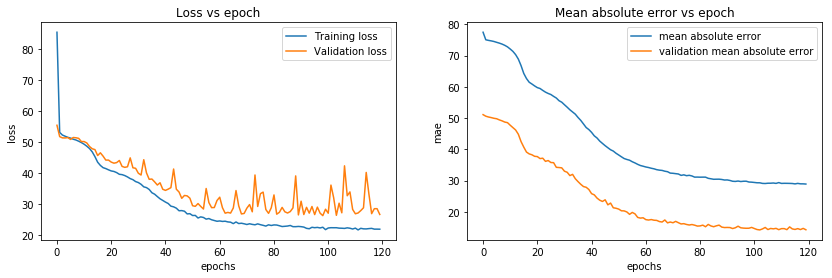

In [214]:
plothistory(history)

In [218]:
def seepredictions(model):
    df_validation = df.loc[df.index[range(train,validation)]].copy()
    #df.tail(len(df)-train).head(validation) #this should work too
    pred = model.predict(x_validate)*1000
    df_validation['Predictions']=pred
    df_validation['DiffPercentage']=abs(df_validation['Predictions']-df_validation['POP10'])/df_validation['POP10']*100
    return df_validation

In [219]:
print('mean percentage diff = ', seepredictions(model)['DiffPercentage'].mean())
val_df = seepredictions(model)
val_df.head()

mean percentage diff =  26.523810384592874


,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,DiffPercentage
2454,18315006,0,36.309616,-78.584242,Oxford,9174,NC,C,7681.052246,16.273684
2579,7014873,16249,41.006614,-95.892941,Plattsmouth,6596,NE,C,5319.627930,19.350698
205,949993185,11742933,30.427885,-91.038912,Baton Rouge,594309,LA,U,620864.000000,4.468214
2591,22650152,1331720,41.318598,-74.939958,Pocono Woodland Lakes,7020,PA,C,11454.448242,63.168778
382,9347987,91039,38.619270,-78.789794,Broadway,6228,VA,C,5296.722168,14.953080


In [220]:
#analyze
l = len(val_df)
val_df.sort_values('Predictions').head(500).tail(20)

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,DiffPercentage
1599,36324085,2628409,58.385608,-134.590425,Juneau,24537,AK,C,9891.271484,59.688342
3127,18300680,0,38.196375,-91.190240,Sullivan,9114,MO,C,10009.821289,9.829068
480,20054972,301025,37.352554,-85.346495,Campbellsville,11719,KY,C,10020.784180,14.491133
3496,18528523,157203,48.165907,-103.633294,Williston,15127,ND,C,10048.679688,33.571232
1044,18013111,136871,39.344591,-94.233558,Excelsior Springs,10943,MO,C,10079.411133,7.891701
1897,20973642,8574,35.890923,-106.290773,Los Alamos,10893,NM,C,10091.182617,7.360850
3373,15784520,0,35.601337,-119.351293,Wasco,25489,CA,C,10098.741211,60.380002
1229,19902926,634,33.406305,-110.797843,Globe,13515,AZ,C,10137.152344,24.993323
1854,17678836,23168,39.178856,-89.647586,Litchfield,6956,IL,C,10180.825195,46.360339
1966,17733218,296206,40.198406,-88.387854,Mahomet,11044,IL,C,10228.756836,7.381774
